In [22]:
# Microsoft Turkey Summer Internship Program Projecy by Defne Meric Erdogan

In [23]:
# Importing libraries for the project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import optuna
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import time

In [24]:
# Importing the dataset
stocks = pd.read_csv('MSFT.csv')

# Data Analysis

In [25]:
print(stocks.head())

         Date      Open      High       Low     Close  Adj Close      Volume
0  1986-03-13  0.088542  0.101563  0.088542  0.097222   0.061434  1031788800
1  1986-03-14  0.097222  0.102431  0.097222  0.100694   0.063628   308160000
2  1986-03-17  0.100694  0.103299  0.100694  0.102431   0.064725   133171200
3  1986-03-18  0.102431  0.103299  0.098958  0.099826   0.063079    67766400
4  1986-03-19  0.099826  0.100694  0.097222  0.098090   0.061982    47894400


In [26]:
print(stocks.describe())

              Open         High          Low        Close    Adj Close  \
count  9083.000000  9083.000000  9083.000000  9083.000000  9083.000000   
mean     41.324936    41.760887    40.878488    41.335628    36.256120   
std      59.696905    60.272218    59.081728    59.714567    59.981436   
min       0.088542     0.092014     0.088542     0.090278     0.057046   
25%       4.050781     4.102051     4.027344     4.075195     2.575089   
50%      26.820000    27.100000    26.520000    26.840000    18.948530   
75%      40.034999    40.443751    39.500000    39.937500    29.244812   
max     344.619995   349.670013   342.200012   343.109985   342.402008   

             Volume  
count  9.083000e+03  
mean   5.875055e+07  
std    3.845200e+07  
min    2.304000e+06  
25%    3.461230e+07  
50%    5.203200e+07  
75%    7.265400e+07  
max    1.031789e+09  


In [27]:
print(stocks.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9083 entries, 0 to 9082
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9083 non-null   object 
 1   Open       9083 non-null   float64
 2   High       9083 non-null   float64
 3   Low        9083 non-null   float64
 4   Close      9083 non-null   float64
 5   Adj Close  9083 non-null   float64
 6   Volume     9083 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 496.9+ KB
None


In [28]:
print(stocks.isnull().sum()) # to check if there are any missing values we need to handle
# There are no missing values in the dataset

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


## Visualizing

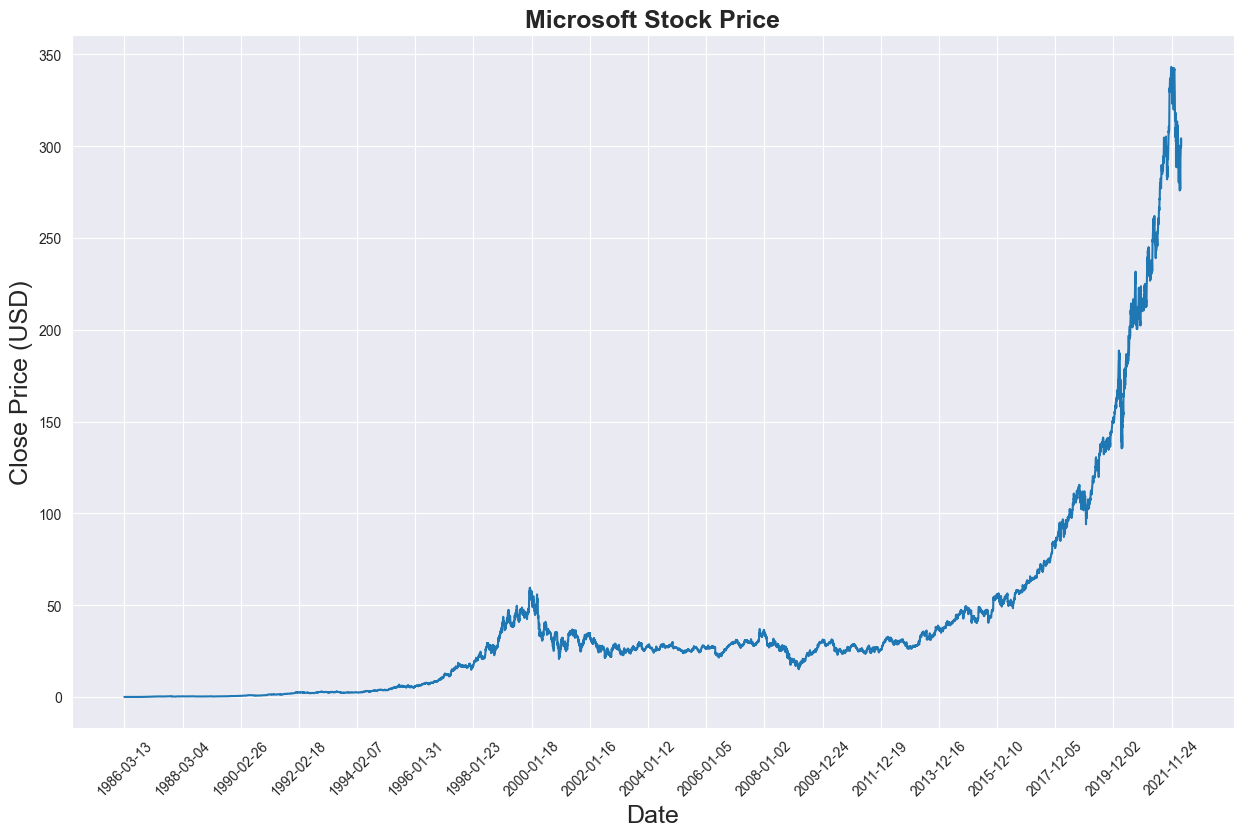

In [29]:
# We see the Close Price of the stock change with the time 
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(stocks['Close'])
plt.xticks(range(0,stocks.shape[0],500),stocks['Date'].loc[::500],rotation=45)
plt.title("Microsoft Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.savefig('images/microsoft_stock_price.png')
plt.show()

## Handling Outliers

In [30]:
# Removes values that fall outside 1.5×IQR range:

Q1 = stocks['Close'].quantile(0.25)
Q3 = stocks['Close'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

stocks = stocks[(stocks['Close'] >= lower_bound) & (stocks['Close'] <= upper_bound)]


In [31]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8076 entries, 0 to 8101
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       8076 non-null   object 
 1   Open       8076 non-null   float64
 2   High       8076 non-null   float64
 3   Low        8076 non-null   float64
 4   Close      8076 non-null   float64
 5   Adj Close  8076 non-null   float64
 6   Volume     8076 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 504.8+ KB


## Normalizing Data

In [32]:
price = stocks[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8076 entries, 0 to 8101
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   8076 non-null   float64
dtypes: float64(1)
memory usage: 126.2 KB


In [33]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price = price.copy()
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

In [34]:
stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061434,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063628,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064725,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063079,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061982,47894400


# Preparation for Model

In [35]:
# Using sliding window method 
# This creates training sampels by taking a sequence of past values and using them to predict the next values.
def split_data(stock, lookback):
    data_raw = stock.to_numpy() 
    data = []
    
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

lookback = 30
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [36]:
# Transforming the data into tensors

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Adding random seed for reproducibility
# 42 as its the Answer to the Ultimate Question of Life :D
torch.manual_seed(42)
np.random.seed(42)
print(f"Using device: {device}")
x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor).to(device)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor).to(device)


Using device: cpu


# LSTM MODEL

In [37]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.linear(out[:, -1, :]) 
        return out

## Finding Best Parameters with HyperParameter Optimization

In [38]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

        return self.early_stop 


In [39]:
def train_model_optuna(model, optimizer, criterion, train_loader, val_loader, epochs=100, patience=10):
    early_stopping = EarlyStopping(patience=patience)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            output = model(x_batch)
            loss = criterion(output, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                output = model(x_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        if early_stopping(val_loss):
            print(f"Early stopping at epoch {epoch}")
            break
    return val_loss


def objective(trial):
    # Suggest hyperparameters
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    # Model
    model = LSTM(input_dim=1, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=1).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Data loaders
    dataset = TensorDataset(x_train, y_train_lstm)
    val_dataset = TensorDataset(x_test, y_test_lstm)

    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    val_loss = train_model_optuna(model, optimizer, criterion, train_loader, val_loader, epochs=100, patience=5)
    return val_loss


In [40]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200, show_progress_bar=True, n_jobs=3)
#study.optimize(objective, n_trials=5)

print("Best trial:")
trial = study.best_trial
for key, value in trial.params.items():
    print(f"{key}: {value}")


[I 2025-07-18 12:13:39,703] A new study created in memory with name: no-name-be8e92b1-db41-446e-9963-5b59ad308243
Best trial: 0. Best value: 0.000760116:   0%|          | 1/200 [00:21<1:11:58, 21.70s/it]

Early stopping at epoch 6
[I 2025-07-18 12:14:01,405] Trial 0 finished with value: 0.0007601156203057982 and parameters: {'hidden_dim': 139, 'num_layers': 1, 'lr': 0.002060450626354424, 'batch_size': 32}. Best is trial 0 with value: 0.0007601156203057982.


Best trial: 0. Best value: 0.000760116:   1%|          | 2/200 [00:35<56:22, 17.09s/it]  

Early stopping at epoch 8
[I 2025-07-18 12:14:15,261] Trial 2 finished with value: 0.0014248763467409075 and parameters: {'hidden_dim': 254, 'num_layers': 1, 'lr': 0.00034619745590265793, 'batch_size': 64}. Best is trial 0 with value: 0.0007601156203057982.


Best trial: 0. Best value: 0.000760116:   2%|▏         | 3/200 [01:14<1:28:56, 27.09s/it]

Early stopping at epoch 10
[I 2025-07-18 12:14:54,252] Trial 4 finished with value: 0.0015474028268905456 and parameters: {'hidden_dim': 210, 'num_layers': 1, 'lr': 0.000510513553523091, 'batch_size': 32}. Best is trial 0 with value: 0.0007601156203057982.


Best trial: 0. Best value: 0.000760116:   2%|▏         | 4/200 [01:36<1:21:26, 24.93s/it]

Early stopping at epoch 10
[I 2025-07-18 12:15:15,876] Trial 5 finished with value: 0.016101385516007073 and parameters: {'hidden_dim': 61, 'num_layers': 3, 'lr': 0.003973502298687336, 'batch_size': 128}. Best is trial 0 with value: 0.0007601156203057982.


Best trial: 0. Best value: 0.000760116:   2%|▎         | 5/200 [02:18<1:41:50, 31.34s/it]

Early stopping at epoch 18
[I 2025-07-18 12:15:58,566] Trial 6 finished with value: 0.012565431017159985 and parameters: {'hidden_dim': 222, 'num_layers': 1, 'lr': 0.0038749806350522288, 'batch_size': 128}. Best is trial 0 with value: 0.0007601156203057982.


Best trial: 0. Best value: 0.000760116:   3%|▎         | 6/200 [02:54<1:45:49, 32.73s/it]

Early stopping at epoch 22
[I 2025-07-18 12:16:33,999] Trial 7 finished with value: 0.002438462583514218 and parameters: {'hidden_dim': 37, 'num_layers': 2, 'lr': 0.0006388189466900082, 'batch_size': 32}. Best is trial 0 with value: 0.0007601156203057982.


Best trial: 1. Best value: 0.000429215:   4%|▎         | 7/200 [03:10<1:28:16, 27.45s/it]

Early stopping at epoch 20
[I 2025-07-18 12:16:50,567] Trial 1 finished with value: 0.0004292149277556318 and parameters: {'hidden_dim': 192, 'num_layers': 3, 'lr': 0.0012945581411475287, 'batch_size': 32}. Best is trial 1 with value: 0.0004292149277556318.


Best trial: 1. Best value: 0.000429215:   4%|▍         | 8/200 [03:41<1:31:11, 28.50s/it]

Early stopping at epoch 25
[I 2025-07-18 12:17:21,312] Trial 3 finished with value: 0.0015922114414256522 and parameters: {'hidden_dim': 126, 'num_layers': 3, 'lr': 0.00010782141899538035, 'batch_size': 32}. Best is trial 1 with value: 0.0004292149277556318.


Best trial: 1. Best value: 0.000429215:   4%|▍         | 9/200 [04:16<1:36:34, 30.34s/it]

Early stopping at epoch 54
[I 2025-07-18 12:17:55,707] Trial 8 finished with value: 0.0029294101332197897 and parameters: {'hidden_dim': 120, 'num_layers': 1, 'lr': 0.00018162630374359812, 'batch_size': 64}. Best is trial 1 with value: 0.0004292149277556318.


Best trial: 1. Best value: 0.000429215:   5%|▌         | 10/200 [04:36<1:26:56, 27.45s/it]

Early stopping at epoch 29
[I 2025-07-18 12:18:16,698] Trial 10 finished with value: 0.00046090358256490205 and parameters: {'hidden_dim': 78, 'num_layers': 1, 'lr': 0.008844789876791574, 'batch_size': 32}. Best is trial 1 with value: 0.0004292149277556318.


Best trial: 1. Best value: 0.000429215:   6%|▌         | 11/200 [04:55<1:17:55, 24.74s/it]

Early stopping at epoch 28
[I 2025-07-18 12:18:35,282] Trial 9 finished with value: 0.0008693251767516474 and parameters: {'hidden_dim': 227, 'num_layers': 1, 'lr': 0.0006607197854232204, 'batch_size': 32}. Best is trial 1 with value: 0.0004292149277556318.


Best trial: 1. Best value: 0.000429215:   6%|▌         | 12/200 [05:22<1:19:21, 25.33s/it]

Early stopping at epoch 6
[I 2025-07-18 12:19:01,946] Trial 12 finished with value: 0.004701023245266138 and parameters: {'hidden_dim': 198, 'num_layers': 2, 'lr': 0.001165114458713188, 'batch_size': 64}. Best is trial 1 with value: 0.0004292149277556318.


Best trial: 11. Best value: 0.00033713:   6%|▋         | 13/200 [05:55<1:26:51, 27.87s/it]

Early stopping at epoch 38
[I 2025-07-18 12:19:35,669] Trial 11 finished with value: 0.0003371301147406204 and parameters: {'hidden_dim': 172, 'num_layers': 1, 'lr': 0.007480640304495269, 'batch_size': 64}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:   7%|▋         | 14/200 [06:52<1:53:01, 36.46s/it]

Early stopping at epoch 15
[I 2025-07-18 12:20:31,974] Trial 14 finished with value: 0.008077829893605382 and parameters: {'hidden_dim': 86, 'num_layers': 3, 'lr': 0.00977760955942196, 'batch_size': 32}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:   8%|▊         | 15/200 [06:52<1:19:08, 25.67s/it]

Early stopping at epoch 17
[I 2025-07-18 12:20:32,634] Trial 13 finished with value: 0.00390113669652469 and parameters: {'hidden_dim': 178, 'num_layers': 2, 'lr': 0.009278966452381542, 'batch_size': 32}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:   8%|▊         | 16/200 [07:57<1:54:35, 37.36s/it]

Early stopping at epoch 11
[I 2025-07-18 12:21:37,161] Trial 16 finished with value: 0.0014425090904786396 and parameters: {'hidden_dim': 178, 'num_layers': 2, 'lr': 0.0017258506600839711, 'batch_size': 64}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:   8%|▊         | 17/200 [09:35<2:49:57, 55.72s/it]

Early stopping at epoch 10
[I 2025-07-18 12:23:15,579] Trial 18 finished with value: 0.004265695962553414 and parameters: {'hidden_dim': 167, 'num_layers': 3, 'lr': 0.0037902418620081838, 'batch_size': 64}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:   9%|▉         | 18/200 [10:33<2:50:46, 56.30s/it]

Early stopping at epoch 33
[I 2025-07-18 12:24:13,228] Trial 15 finished with value: 0.003147928143264905 and parameters: {'hidden_dim': 166, 'num_layers': 3, 'lr': 0.00911531406937801, 'batch_size': 64}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  10%|▉         | 19/200 [10:41<2:06:05, 41.80s/it]

Early stopping at epoch 27
[I 2025-07-18 12:24:21,239] Trial 17 finished with value: 0.00199405643042365 and parameters: {'hidden_dim': 166, 'num_layers': 3, 'lr': 0.0017138417134332738, 'batch_size': 64}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  10%|█         | 20/200 [11:20<2:02:48, 40.93s/it]

Early stopping at epoch 27
[I 2025-07-18 12:25:00,160] Trial 19 finished with value: 0.00201700035372946 and parameters: {'hidden_dim': 154, 'num_layers': 2, 'lr': 0.002317155402922804, 'batch_size': 128}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  10%|█         | 21/200 [12:08<2:08:02, 42.92s/it]

Early stopping at epoch 14
[I 2025-07-18 12:25:47,715] Trial 21 finished with value: 0.004224023550005558 and parameters: {'hidden_dim': 245, 'num_layers': 2, 'lr': 0.005342066173561987, 'batch_size': 128}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  11%|█         | 22/200 [12:13<1:33:43, 31.59s/it]

Early stopping at epoch 16
[I 2025-07-18 12:25:52,884] Trial 20 finished with value: 0.0017211970385128202 and parameters: {'hidden_dim': 254, 'num_layers': 2, 'lr': 0.002208330933603275, 'batch_size': 128}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  12%|█▏        | 23/200 [12:42<1:31:10, 30.91s/it]

Early stopping at epoch 10
[I 2025-07-18 12:26:22,195] Trial 24 finished with value: 0.001080332660528845 and parameters: {'hidden_dim': 100, 'num_layers': 1, 'lr': 0.005529135464144059, 'batch_size': 32}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  12%|█▏        | 24/200 [13:05<1:23:57, 28.62s/it]

Early stopping at epoch 21
[I 2025-07-18 12:26:45,496] Trial 23 finished with value: 0.000494203532677299 and parameters: {'hidden_dim': 96, 'num_layers': 1, 'lr': 0.00636802268862105, 'batch_size': 32}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  12%|█▎        | 25/200 [13:59<1:45:41, 36.24s/it]

Early stopping at epoch 26
[I 2025-07-18 12:27:39,497] Trial 22 finished with value: 0.014389258466857987 and parameters: {'hidden_dim': 251, 'num_layers': 2, 'lr': 0.005931324167685746, 'batch_size': 128}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  13%|█▎        | 26/200 [14:29<1:39:13, 34.22s/it]

Early stopping at epoch 22
[I 2025-07-18 12:28:08,998] Trial 26 finished with value: 0.0012490904921957967 and parameters: {'hidden_dim': 192, 'num_layers': 1, 'lr': 0.002896909369861689, 'batch_size': 32}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  14%|█▎        | 27/200 [14:45<1:23:06, 28.83s/it]

Early stopping at epoch 12
[I 2025-07-18 12:28:25,248] Trial 27 finished with value: 0.0007272958520807864 and parameters: {'hidden_dim': 193, 'num_layers': 1, 'lr': 0.0011832037893096752, 'batch_size': 32}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  14%|█▍        | 28/200 [14:53<1:04:50, 22.62s/it]

Early stopping at epoch 34
[I 2025-07-18 12:28:33,382] Trial 25 finished with value: 0.0008151328291597904 and parameters: {'hidden_dim': 194, 'num_layers': 1, 'lr': 0.005517676981065983, 'batch_size': 32}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  14%|█▍        | 29/200 [15:04<54:39, 19.18s/it]  

Early stopping at epoch 44
[I 2025-07-18 12:28:44,525] Trial 28 finished with value: 0.0006099505480604278 and parameters: {'hidden_dim': 32, 'num_layers': 1, 'lr': 0.0011931559032341344, 'batch_size': 32}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  15%|█▌        | 30/200 [16:06<1:30:13, 31.84s/it]

Early stopping at epoch 13
[I 2025-07-18 12:29:45,926] Trial 30 finished with value: 0.0028150638110953597 and parameters: {'hidden_dim': 140, 'num_layers': 2, 'lr': 0.0002246121318265942, 'batch_size': 64}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  16%|█▌        | 31/200 [16:43<1:34:23, 33.51s/it]

Early stopping at epoch 23
[I 2025-07-18 12:30:23,335] Trial 29 finished with value: 0.002443608630318732 and parameters: {'hidden_dim': 140, 'num_layers': 2, 'lr': 0.0002622245769035815, 'batch_size': 64}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  16%|█▌        | 32/200 [17:26<1:41:21, 36.20s/it]

Early stopping at epoch 20
[I 2025-07-18 12:31:05,804] Trial 33 finished with value: 0.0010015823689743639 and parameters: {'hidden_dim': 84, 'num_layers': 1, 'lr': 0.007218122594477751, 'batch_size': 32}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  16%|█▋        | 33/200 [17:30<1:14:06, 26.62s/it]

Early stopping at epoch 17
[I 2025-07-18 12:31:10,086] Trial 32 finished with value: 0.01254191640859622 and parameters: {'hidden_dim': 120, 'num_layers': 3, 'lr': 0.0030192806155876005, 'batch_size': 64}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  17%|█▋        | 34/200 [17:41<1:01:05, 22.08s/it]

Early stopping at epoch 12
[I 2025-07-18 12:31:21,557] Trial 34 finished with value: 0.0007752109016413063 and parameters: {'hidden_dim': 63, 'num_layers': 1, 'lr': 0.0068479826140914225, 'batch_size': 32}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  18%|█▊        | 35/200 [17:49<48:39, 17.69s/it]  

Early stopping at epoch 15
[I 2025-07-18 12:31:29,015] Trial 35 finished with value: 0.0005393364031881313 and parameters: {'hidden_dim': 61, 'num_layers': 1, 'lr': 0.0063709170480396, 'batch_size': 32}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  18%|█▊        | 36/200 [17:53<36:54, 13.50s/it]

Early stopping at epoch 23
[I 2025-07-18 12:31:32,742] Trial 31 finished with value: 0.0034163712015679967 and parameters: {'hidden_dim': 139, 'num_layers': 3, 'lr': 0.00029687717711646117, 'batch_size': 64}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  18%|█▊        | 37/200 [18:07<37:41, 13.87s/it]

Early stopping at epoch 10
[I 2025-07-18 12:31:47,476] Trial 36 finished with value: 0.0012832727334884397 and parameters: {'hidden_dim': 100, 'num_layers': 1, 'lr': 0.0073277311856272, 'batch_size': 32}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  19%|█▉        | 38/200 [18:08<26:35,  9.85s/it]

Early stopping at epoch 7
[I 2025-07-18 12:31:47,947] Trial 37 finished with value: 0.0006574648583659391 and parameters: {'hidden_dim': 103, 'num_layers': 1, 'lr': 0.0041795249919393965, 'batch_size': 32}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  20%|█▉        | 39/200 [18:31<37:24, 13.94s/it]

Early stopping at epoch 24
[I 2025-07-18 12:32:11,423] Trial 40 finished with value: 0.0003503048544956198 and parameters: {'hidden_dim': 46, 'num_layers': 1, 'lr': 0.004549283899141453, 'batch_size': 32}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  20%|██        | 40/200 [18:34<28:20, 10.63s/it]

Early stopping at epoch 27
[I 2025-07-18 12:32:14,316] Trial 39 finished with value: 0.001597518406710793 and parameters: {'hidden_dim': 50, 'num_layers': 1, 'lr': 0.00046038686084056156, 'batch_size': 32}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  20%|██        | 41/200 [18:51<32:50, 12.39s/it]

Early stopping at epoch 20
[I 2025-07-18 12:32:30,836] Trial 41 finished with value: 0.0017189097015230515 and parameters: {'hidden_dim': 46, 'num_layers': 1, 'lr': 0.00047375005339606377, 'batch_size': 32}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  21%|██        | 42/200 [18:59<29:19, 11.14s/it]

Early stopping at epoch 26
[I 2025-07-18 12:32:39,041] Trial 42 finished with value: 0.0004917726843154478 and parameters: {'hidden_dim': 46, 'num_layers': 1, 'lr': 0.004405483352544617, 'batch_size': 32}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  22%|██▏       | 43/200 [19:00<21:09,  8.08s/it]

Early stopping at epoch 29
[I 2025-07-18 12:32:39,999] Trial 38 finished with value: 0.00036405888799801654 and parameters: {'hidden_dim': 94, 'num_layers': 1, 'lr': 0.004317200404618483, 'batch_size': 32}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  22%|██▏       | 44/200 [19:28<36:53, 14.19s/it]

Early stopping at epoch 15
[I 2025-07-18 12:33:08,424] Trial 45 finished with value: 0.00041499222678277305 and parameters: {'hidden_dim': 70, 'num_layers': 1, 'lr': 0.0030658627873576456, 'batch_size': 32}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 11. Best value: 0.00033713:  22%|██▎       | 45/200 [19:31<27:49, 10.77s/it]

Early stopping at epoch 21
[I 2025-07-18 12:33:11,229] Trial 43 finished with value: 0.00041166750873112597 and parameters: {'hidden_dim': 77, 'num_layers': 1, 'lr': 0.0045595675400860606, 'batch_size': 32}. Best is trial 11 with value: 0.0003371301147406204.


Best trial: 44. Best value: 0.000272148:  23%|██▎       | 46/200 [19:41<27:15, 10.62s/it]

Early stopping at epoch 22
[I 2025-07-18 12:33:21,496] Trial 44 finished with value: 0.0002721482710958477 and parameters: {'hidden_dim': 73, 'num_layers': 1, 'lr': 0.0045062085656369, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  24%|██▎       | 47/200 [20:00<33:38, 13.19s/it]

Early stopping at epoch 7
[I 2025-07-18 12:33:40,685] Trial 46 finished with value: 0.0007803745144937077 and parameters: {'hidden_dim': 217, 'num_layers': 1, 'lr': 0.002983972762008917, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  24%|██▍       | 48/200 [20:17<35:40, 14.09s/it]

Early stopping at epoch 21
[I 2025-07-18 12:33:56,855] Trial 47 finished with value: 0.0005925989732050392 and parameters: {'hidden_dim': 73, 'num_layers': 1, 'lr': 0.003098001334599464, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  24%|██▍       | 49/200 [20:21<28:12, 11.21s/it]

Early stopping at epoch 10
[I 2025-07-18 12:34:01,364] Trial 49 finished with value: 0.0006117317742809616 and parameters: {'hidden_dim': 68, 'num_layers': 1, 'lr': 0.004693905964888028, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.
Early stopping at epoch 14
[I 2025-07-18 12:34:01,425] Trial 48 finished with value: 0.0009690086715672092 and parameters: {'hidden_dim': 111, 'num_layers': 1, 'lr': 0.0046646323415248684, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  26%|██▌       | 51/200 [20:53<33:14, 13.39s/it]

Early stopping at epoch 22
[I 2025-07-18 12:34:33,222] Trial 52 finished with value: 0.0015419833101847102 and parameters: {'hidden_dim': 87, 'num_layers': 1, 'lr': 0.001876879285801335, 'batch_size': 64}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  26%|██▌       | 52/200 [21:12<36:41, 14.88s/it]

Early stopping at epoch 19
[I 2025-07-18 12:34:52,618] Trial 50 finished with value: 0.0002961579332038002 and parameters: {'hidden_dim': 113, 'num_layers': 1, 'lr': 0.0049035780128567534, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  26%|██▋       | 53/200 [21:25<35:15, 14.39s/it]

Early stopping at epoch 11
[I 2025-07-18 12:35:05,627] Trial 54 finished with value: 0.000591148511625315 and parameters: {'hidden_dim': 53, 'num_layers': 1, 'lr': 0.003608516981826586, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  27%|██▋       | 54/200 [21:26<25:40, 10.55s/it]

Early stopping at epoch 14
[I 2025-07-18 12:35:05,911] Trial 53 finished with value: 0.0005605713660199899 and parameters: {'hidden_dim': 77, 'num_layers': 1, 'lr': 0.0035055438104444844, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  28%|██▊       | 55/200 [22:05<45:07, 18.67s/it]

Early stopping at epoch 20
[I 2025-07-18 12:35:45,464] Trial 56 finished with value: 0.0010246140871179076 and parameters: {'hidden_dim': 153, 'num_layers': 1, 'lr': 0.002464250956262986, 'batch_size': 128}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  28%|██▊       | 56/200 [22:15<38:27, 16.02s/it]

[I 2025-07-18 12:35:54,867] Trial 51 finished with value: 0.003974250968894921 and parameters: {'hidden_dim': 56, 'num_layers': 1, 'lr': 0.0001151030146428118, 'batch_size': 64}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  28%|██▊       | 57/200 [22:18<29:21, 12.32s/it]

Early stopping at epoch 17
[I 2025-07-18 12:35:58,111] Trial 55 finished with value: 0.00031505242776463504 and parameters: {'hidden_dim': 113, 'num_layers': 1, 'lr': 0.007818414248690012, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  29%|██▉       | 58/200 [23:02<51:11, 21.63s/it]

Early stopping at epoch 17
[I 2025-07-18 12:36:42,242] Trial 57 finished with value: 0.0007712804505775007 and parameters: {'hidden_dim': 129, 'num_layers': 1, 'lr': 0.007523953797979348, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  30%|██▉       | 59/200 [23:28<53:31, 22.77s/it]

Early stopping at epoch 21
[I 2025-07-18 12:37:07,746] Trial 59 finished with value: 0.0003159746061725195 and parameters: {'hidden_dim': 129, 'num_layers': 1, 'lr': 0.008255277439500679, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  30%|███       | 60/200 [23:41<46:24, 19.89s/it]

Early stopping at epoch 29
[I 2025-07-18 12:37:20,786] Trial 58 finished with value: 0.0008930942791516381 and parameters: {'hidden_dim': 108, 'num_layers': 1, 'lr': 0.007668517304355515, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  30%|███       | 61/200 [23:59<44:56, 19.40s/it]

Early stopping at epoch 19
[I 2025-07-18 12:37:39,026] Trial 61 finished with value: 0.0006755691552266049 and parameters: {'hidden_dim': 119, 'num_layers': 1, 'lr': 0.008226704333581806, 'batch_size': 128}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  31%|███       | 62/200 [24:10<38:51, 16.89s/it]

Early stopping at epoch 18
[I 2025-07-18 12:37:50,020] Trial 62 finished with value: 0.0028135959202280412 and parameters: {'hidden_dim': 115, 'num_layers': 1, 'lr': 0.00978005266250067, 'batch_size': 128}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  32%|███▏      | 63/200 [24:15<30:48, 13.49s/it]

Early stopping at epoch 26
[I 2025-07-18 12:37:55,530] Trial 60 finished with value: 0.0005454152346561279 and parameters: {'hidden_dim': 110, 'num_layers': 1, 'lr': 0.008252443659149029, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  32%|███▏      | 64/200 [24:27<29:31, 13.03s/it]

Early stopping at epoch 5
[I 2025-07-18 12:38:07,460] Trial 64 finished with value: 0.0016762337323669664 and parameters: {'hidden_dim': 124, 'num_layers': 1, 'lr': 0.00546250972759261, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  32%|███▎      | 65/200 [24:35<25:49, 11.48s/it]

Early stopping at epoch 11
[I 2025-07-18 12:38:15,314] Trial 63 finished with value: 0.00038204491654908576 and parameters: {'hidden_dim': 133, 'num_layers': 1, 'lr': 0.00924534895723438, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  33%|███▎      | 66/200 [24:42<22:19,  9.99s/it]

Early stopping at epoch 8
[I 2025-07-18 12:38:21,846] Trial 65 finished with value: 0.0020559299380550453 and parameters: {'hidden_dim': 130, 'num_layers': 1, 'lr': 0.005394993338978531, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  34%|███▎      | 67/200 [25:03<30:01, 13.54s/it]

Early stopping at epoch 12
[I 2025-07-18 12:38:43,683] Trial 67 finished with value: 0.00045596541966398376 and parameters: {'hidden_dim': 91, 'num_layers': 1, 'lr': 0.0051974194250439115, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  34%|███▍      | 68/200 [25:19<31:17, 14.22s/it]

Early stopping at epoch 22
[I 2025-07-18 12:38:59,488] Trial 66 finished with value: 0.0006308299890210322 and parameters: {'hidden_dim': 94, 'num_layers': 1, 'lr': 0.0015398392319990475, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  34%|███▍      | 69/200 [25:25<25:25, 11.65s/it]

Early stopping at epoch 15
[I 2025-07-18 12:39:05,118] Trial 69 finished with value: 0.0007191369413004185 and parameters: {'hidden_dim': 94, 'num_layers': 1, 'lr': 0.0009225622472015208, 'batch_size': 64}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  35%|███▌      | 70/200 [25:51<34:20, 15.85s/it]

Early stopping at epoch 26
[I 2025-07-18 12:39:30,782] Trial 68 finished with value: 0.0009704036559784212 and parameters: {'hidden_dim': 94, 'num_layers': 2, 'lr': 0.0009117988755482203, 'batch_size': 64}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  36%|███▌      | 71/200 [25:54<25:51, 12.03s/it]

Early stopping at epoch 6
[I 2025-07-18 12:39:33,890] Trial 70 finished with value: 0.004751526530106695 and parameters: {'hidden_dim': 148, 'num_layers': 2, 'lr': 0.006317912616689338, 'batch_size': 64}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  36%|███▌      | 72/200 [26:00<21:41, 10.17s/it]

Early stopping at epoch 5
[I 2025-07-18 12:39:39,709] Trial 71 finished with value: 0.014373393615152543 and parameters: {'hidden_dim': 177, 'num_layers': 2, 'lr': 0.006336157528728048, 'batch_size': 64}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  36%|███▋      | 73/200 [26:30<34:28, 16.29s/it]

Early stopping at epoch 11
[I 2025-07-18 12:40:10,282] Trial 74 finished with value: 0.0003690398730481427 and parameters: {'hidden_dim': 131, 'num_layers': 1, 'lr': 0.009813131086987696, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  37%|███▋      | 74/200 [26:33<25:29, 12.14s/it]

Early stopping at epoch 14
[I 2025-07-18 12:40:12,742] Trial 73 finished with value: 0.00035057776517978886 and parameters: {'hidden_dim': 131, 'num_layers': 1, 'lr': 0.009923235917788419, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  38%|███▊      | 75/200 [26:53<30:44, 14.75s/it]

Early stopping at epoch 10
[I 2025-07-18 12:40:33,595] Trial 72 finished with value: 0.0023325532098419453 and parameters: {'hidden_dim': 153, 'num_layers': 2, 'lr': 0.006395501111364449, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  38%|███▊      | 76/200 [27:07<30:02, 14.54s/it]

Early stopping at epoch 12
[I 2025-07-18 12:40:47,622] Trial 75 finished with value: 0.001211959412281502 and parameters: {'hidden_dim': 160, 'num_layers': 1, 'lr': 0.009836692513647539, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  38%|███▊      | 77/200 [27:31<35:15, 17.20s/it]

Early stopping at epoch 11
[I 2025-07-18 12:41:11,046] Trial 77 finished with value: 0.0004489479598465978 and parameters: {'hidden_dim': 163, 'num_layers': 1, 'lr': 0.00840669440928793, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  39%|███▉      | 78/200 [27:41<30:32, 15.02s/it]

Early stopping at epoch 10
[I 2025-07-18 12:41:20,969] Trial 78 finished with value: 0.0012062319293167378 and parameters: {'hidden_dim': 145, 'num_layers': 1, 'lr': 0.002559828387090673, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  40%|███▉      | 79/200 [27:56<30:08, 14.94s/it]

Early stopping at epoch 26
[I 2025-07-18 12:41:35,742] Trial 76 finished with value: 0.0005106576498684601 and parameters: {'hidden_dim': 162, 'num_layers': 1, 'lr': 0.00844999482699161, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  40%|████      | 80/200 [28:46<51:01, 25.51s/it]

Early stopping at epoch 31
[I 2025-07-18 12:42:25,903] Trial 79 finished with value: 0.00030202286464319677 and parameters: {'hidden_dim': 104, 'num_layers': 1, 'lr': 0.004126353983977184, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  40%|████      | 81/200 [28:48<36:42, 18.51s/it]

Early stopping at epoch 27
[I 2025-07-18 12:42:28,087] Trial 80 finished with value: 0.0003873091537018042 and parameters: {'hidden_dim': 106, 'num_layers': 1, 'lr': 0.0037260972623560443, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  41%|████      | 82/200 [28:49<26:22, 13.41s/it]

Early stopping at epoch 22
[I 2025-07-18 12:42:29,584] Trial 81 finished with value: 0.00047083468462897504 and parameters: {'hidden_dim': 103, 'num_layers': 1, 'lr': 0.004057417574747214, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  42%|████▏     | 83/200 [29:17<34:38, 17.76s/it]

Early stopping at epoch 10
[I 2025-07-18 12:42:57,504] Trial 84 finished with value: 0.0015743280422540527 and parameters: {'hidden_dim': 116, 'num_layers': 1, 'lr': 0.005141192557702149, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  42%|████▏     | 84/200 [29:27<29:55, 15.48s/it]

Early stopping at epoch 14
[I 2025-07-18 12:43:07,652] Trial 83 finished with value: 0.000336790601852722 and parameters: {'hidden_dim': 122, 'num_layers': 1, 'lr': 0.004784482824891388, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  42%|████▎     | 85/200 [29:30<22:13, 11.60s/it]

Early stopping at epoch 14
[I 2025-07-18 12:43:10,206] Trial 85 finished with value: 0.0005320978204562219 and parameters: {'hidden_dim': 39, 'num_layers': 1, 'lr': 0.00698896811027895, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  43%|████▎     | 86/200 [29:53<28:24, 14.95s/it]

Early stopping at epoch 26
[I 2025-07-18 12:43:32,970] Trial 82 finished with value: 0.0008770762413441131 and parameters: {'hidden_dim': 104, 'num_layers': 1, 'lr': 0.003664405650956733, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  44%|████▎     | 87/200 [30:02<24:45, 13.15s/it]

Early stopping at epoch 11
[I 2025-07-18 12:43:41,918] Trial 86 finished with value: 0.000498722279706842 and parameters: {'hidden_dim': 134, 'num_layers': 1, 'lr': 0.007028544544651347, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  44%|████▍     | 88/200 [30:05<19:03, 10.21s/it]

Early stopping at epoch 12
[I 2025-07-18 12:43:45,262] Trial 87 finished with value: 0.0006513814171151299 and parameters: {'hidden_dim': 123, 'num_layers': 1, 'lr': 0.005776462232984185, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  44%|████▍     | 89/200 [30:27<25:18, 13.68s/it]

Early stopping at epoch 12
[I 2025-07-18 12:44:07,060] Trial 88 finished with value: 0.0015736022050630565 and parameters: {'hidden_dim': 124, 'num_layers': 1, 'lr': 0.005900595861129016, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  45%|████▌     | 90/200 [30:34<21:14, 11.58s/it]

Early stopping at epoch 9
[I 2025-07-18 12:44:13,739] Trial 90 finished with value: 0.0008119177044707113 and parameters: {'hidden_dim': 137, 'num_layers': 1, 'lr': 0.00487673252216906, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  46%|████▌     | 91/200 [30:41<18:52, 10.39s/it]

Early stopping at epoch 14
[I 2025-07-18 12:44:21,359] Trial 89 finished with value: 0.0012382051897350489 and parameters: {'hidden_dim': 123, 'num_layers': 1, 'lr': 0.005821905694265376, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  46%|████▌     | 92/200 [30:54<20:06, 11.17s/it]

Early stopping at epoch 16
[I 2025-07-18 12:44:34,348] Trial 91 finished with value: 0.002309226762288465 and parameters: {'hidden_dim': 140, 'num_layers': 1, 'lr': 0.004914227312298666, 'batch_size': 128}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  46%|████▋     | 93/200 [30:57<15:43,  8.82s/it]

Early stopping at epoch 12
[I 2025-07-18 12:44:37,673] Trial 92 finished with value: 0.0018952539730190227 and parameters: {'hidden_dim': 174, 'num_layers': 1, 'lr': 0.0074496812396266515, 'batch_size': 128}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  47%|████▋     | 94/200 [31:32<29:27, 16.68s/it]

Early stopping at epoch 17
[I 2025-07-18 12:45:12,685] Trial 95 finished with value: 0.0010952464380191967 and parameters: {'hidden_dim': 83, 'num_layers': 1, 'lr': 0.0033620850125702763, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  48%|████▊     | 95/200 [31:40<24:28, 13.98s/it]

Early stopping at epoch 29
[I 2025-07-18 12:45:20,384] Trial 93 finished with value: 0.00036637919958379557 and parameters: {'hidden_dim': 88, 'num_layers': 1, 'lr': 0.00423503277028256, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  48%|████▊     | 96/200 [31:51<22:47, 13.15s/it]

Early stopping at epoch 28
[I 2025-07-18 12:45:31,591] Trial 94 finished with value: 0.0005487777241654055 and parameters: {'hidden_dim': 85, 'num_layers': 1, 'lr': 0.004216755577894546, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  48%|████▊     | 97/200 [32:02<21:22, 12.45s/it]

Early stopping at epoch 8
[I 2025-07-18 12:45:42,419] Trial 97 finished with value: 0.000819912840847346 and parameters: {'hidden_dim': 115, 'num_layers': 1, 'lr': 0.004279139160778064, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  50%|████▉     | 99/200 [32:14<14:29,  8.61s/it]

Early stopping at epoch 8
[I 2025-07-18 12:45:54,182] Trial 98 finished with value: 0.0008282908901866689 and parameters: {'hidden_dim': 114, 'num_layers': 1, 'lr': 0.0080207823566357, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.
Early stopping at epoch 16
[I 2025-07-18 12:45:54,315] Trial 96 finished with value: 0.0006922784165248694 and parameters: {'hidden_dim': 114, 'num_layers': 1, 'lr': 0.0026997831593149817, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  50%|█████     | 100/200 [32:34<19:49, 11.89s/it]

Early stopping at epoch 12
[I 2025-07-18 12:46:13,867] Trial 101 finished with value: 0.002894846176227125 and parameters: {'hidden_dim': 100, 'num_layers': 1, 'lr': 0.008955127778534055, 'batch_size': 64}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  50%|█████     | 101/200 [32:48<20:42, 12.55s/it]

Early stopping at epoch 17
[I 2025-07-18 12:46:27,940] Trial 99 finished with value: 0.0007447402905895348 and parameters: {'hidden_dim': 98, 'num_layers': 1, 'lr': 0.008767933891658725, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  51%|█████     | 102/200 [32:48<14:30,  8.89s/it]

Early stopping at epoch 9
[I 2025-07-18 12:46:28,281] Trial 100 finished with value: 0.0009809452343438798 and parameters: {'hidden_dim': 200, 'num_layers': 1, 'lr': 0.0032926818026000793, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  52%|█████▏    | 103/200 [33:05<18:03, 11.17s/it]

Early stopping at epoch 8
[I 2025-07-18 12:46:44,764] Trial 102 finished with value: 0.000719483476560152 and parameters: {'hidden_dim': 198, 'num_layers': 1, 'lr': 0.0066679655640614266, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  52%|█████▏    | 104/200 [33:10<15:04,  9.42s/it]

Early stopping at epoch 10
[I 2025-07-18 12:46:50,113] Trial 103 finished with value: 0.001354656491885715 and parameters: {'hidden_dim': 89, 'num_layers': 1, 'lr': 0.0034051781789178662, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  52%|█████▎    | 105/200 [33:45<27:16, 17.23s/it]

Early stopping at epoch 21
[I 2025-07-18 12:47:25,555] Trial 105 finished with value: 0.0007242967931590244 and parameters: {'hidden_dim': 67, 'num_layers': 1, 'lr': 0.003923316923885872, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  53%|█████▎    | 106/200 [34:13<32:04, 20.48s/it]

Early stopping at epoch 26
[I 2025-07-18 12:47:53,609] Trial 104 finished with value: 0.0004499539685567987 and parameters: {'hidden_dim': 185, 'num_layers': 1, 'lr': 0.004567859023497323, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 44. Best value: 0.000272148:  54%|█████▎    | 107/200 [34:19<24:49, 16.02s/it]

Early stopping at epoch 35
[I 2025-07-18 12:47:59,236] Trial 106 finished with value: 0.00037764706683126003 and parameters: {'hidden_dim': 80, 'num_layers': 1, 'lr': 0.003874919760605547, 'batch_size': 32}. Best is trial 44 with value: 0.0002721482710958477.


Best trial: 107. Best value: 0.000252917:  54%|█████▍    | 108/200 [34:29<21:59, 14.34s/it]

Early stopping at epoch 22
[I 2025-07-18 12:48:09,646] Trial 107 finished with value: 0.0002529166177184522 and parameters: {'hidden_dim': 80, 'num_layers': 1, 'lr': 0.0045240953459824255, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  55%|█████▍    | 109/200 [34:46<22:32, 14.86s/it]

Early stopping at epoch 12
[I 2025-07-18 12:48:25,735] Trial 108 finished with value: 0.0006944418247953496 and parameters: {'hidden_dim': 110, 'num_layers': 1, 'lr': 0.005054396435528096, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  55%|█████▌    | 110/200 [34:48<16:55, 11.29s/it]

Early stopping at epoch 16
[I 2025-07-18 12:48:28,676] Trial 110 finished with value: 0.0007110110407386225 and parameters: {'hidden_dim': 73, 'num_layers': 1, 'lr': 0.00501440093168406, 'batch_size': 64}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  56%|█████▌    | 111/200 [34:58<15:47, 10.65s/it]

Early stopping at epoch 11
[I 2025-07-18 12:48:37,827] Trial 111 finished with value: 0.0010888928781451585 and parameters: {'hidden_dim': 59, 'num_layers': 1, 'lr': 0.0020338139451744723, 'batch_size': 64}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  56%|█████▌    | 112/200 [35:08<15:31, 10.59s/it]

Early stopping at epoch 25
[I 2025-07-18 12:48:48,279] Trial 109 finished with value: 0.00030478924257776644 and parameters: {'hidden_dim': 73, 'num_layers': 1, 'lr': 0.004988840848156572, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  56%|█████▋    | 113/200 [35:27<19:01, 13.12s/it]

Early stopping at epoch 15
[I 2025-07-18 12:49:07,294] Trial 112 finished with value: 0.0008426382815278153 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'lr': 0.0027702969010082452, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  57%|█████▋    | 114/200 [35:32<15:25, 10.76s/it]

Early stopping at epoch 17
[I 2025-07-18 12:49:12,548] Trial 113 finished with value: 0.0003777156539310418 and parameters: {'hidden_dim': 79, 'num_layers': 1, 'lr': 0.00445105490426678, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  57%|█████▊    | 115/200 [35:43<15:21, 10.85s/it]

Early stopping at epoch 13
[I 2025-07-18 12:49:23,599] Trial 114 finished with value: 0.0012267523976761902 and parameters: {'hidden_dim': 119, 'num_layers': 1, 'lr': 0.006719346689477958, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  58%|█████▊    | 116/200 [35:53<14:31, 10.38s/it]

Early stopping at epoch 12
[I 2025-07-18 12:49:32,877] Trial 115 finished with value: 0.0010215119964057378 and parameters: {'hidden_dim': 77, 'num_layers': 1, 'lr': 0.006162651003537068, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  58%|█████▊    | 117/200 [36:00<13:10,  9.52s/it]

Early stopping at epoch 17
[I 2025-07-18 12:49:40,418] Trial 117 finished with value: 0.00040512902406215505 and parameters: {'hidden_dim': 44, 'num_layers': 1, 'lr': 0.0060182399809242774, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  59%|█████▉    | 118/200 [36:13<14:15, 10.43s/it]

Early stopping at epoch 9
[I 2025-07-18 12:49:52,966] Trial 116 finished with value: 0.0013840761519389286 and parameters: {'hidden_dim': 236, 'num_layers': 1, 'lr': 0.0060769188630648355, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  60%|█████▉    | 119/200 [36:26<15:09, 11.23s/it]

Early stopping at epoch 11
[I 2025-07-18 12:50:06,070] Trial 120 finished with value: 0.001976538169330132 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'lr': 0.005434773017241205, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  60%|██████    | 120/200 [36:40<16:11, 12.14s/it]

Early stopping at epoch 18
[I 2025-07-18 12:50:20,340] Trial 119 finished with value: 0.0002770296884466684 and parameters: {'hidden_dim': 65, 'num_layers': 1, 'lr': 0.005507775847740057, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  60%|██████    | 121/200 [36:53<16:16, 12.37s/it]

Early stopping at epoch 11
[I 2025-07-18 12:50:33,220] Trial 122 finished with value: 0.0006643343186428241 and parameters: {'hidden_dim': 54, 'num_layers': 1, 'lr': 0.007716735163159273, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  61%|██████    | 122/200 [37:08<17:14, 13.27s/it]

Early stopping at epoch 17
[I 2025-07-18 12:50:48,597] Trial 118 finished with value: 0.0004697356836878302 and parameters: {'hidden_dim': 239, 'num_layers': 1, 'lr': 0.007821064620792607, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  62%|██████▏   | 123/200 [37:16<14:47, 11.53s/it]

Early stopping at epoch 11
[I 2025-07-18 12:50:56,059] Trial 123 finished with value: 0.0007895395603697455 and parameters: {'hidden_dim': 73, 'num_layers': 1, 'lr': 0.005514624323596157, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  62%|██████▏   | 124/200 [37:34<17:09, 13.55s/it]

Early stopping at epoch 32
[I 2025-07-18 12:51:14,333] Trial 121 finished with value: 0.0008528464303726293 and parameters: {'hidden_dim': 71, 'num_layers': 1, 'lr': 0.0007143502199921559, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  62%|██████▎   | 125/200 [37:46<16:15, 13.01s/it]

Early stopping at epoch 17
[I 2025-07-18 12:51:26,074] Trial 124 finished with value: 0.0003355503212885963 and parameters: {'hidden_dim': 72, 'num_layers': 1, 'lr': 0.005507341181520801, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  63%|██████▎   | 126/200 [37:52<13:31, 10.97s/it]

Early stopping at epoch 7
[I 2025-07-18 12:51:32,300] Trial 126 finished with value: 0.0006841402395295125 and parameters: {'hidden_dim': 83, 'num_layers': 1, 'lr': 0.004633383034032544, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  64%|██████▎   | 127/200 [38:04<13:34, 11.16s/it]

Early stopping at epoch 14
[I 2025-07-18 12:51:43,889] Trial 127 finished with value: 0.0005849539599034424 and parameters: {'hidden_dim': 59, 'num_layers': 1, 'lr': 0.007082324476552912, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  64%|██████▍   | 128/200 [38:13<12:37, 10.52s/it]

Early stopping at epoch 17
[I 2025-07-18 12:51:52,914] Trial 128 finished with value: 0.000452356434727656 and parameters: {'hidden_dim': 57, 'num_layers': 1, 'lr': 0.00669189667778463, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  64%|██████▍   | 129/200 [38:14<09:11,  7.77s/it]

Early stopping at epoch 9
[I 2025-07-18 12:51:54,284] Trial 129 finished with value: 0.0022611356875060274 and parameters: {'hidden_dim': 48, 'num_layers': 1, 'lr': 0.008893951949923628, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  65%|██████▌   | 130/200 [38:28<11:06,  9.52s/it]

Early stopping at epoch 22
[I 2025-07-18 12:52:07,873] Trial 131 finished with value: 0.0032806239458015906 and parameters: {'hidden_dim': 37, 'num_layers': 1, 'lr': 0.005453625563291661, 'batch_size': 128}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  66%|██████▌   | 131/200 [38:36<10:41,  9.29s/it]

Early stopping at epoch 28
[I 2025-07-18 12:52:16,645] Trial 130 finished with value: 0.0008781673918397595 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'lr': 0.009117326655138987, 'batch_size': 128}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  66%|██████▌   | 132/200 [38:39<08:05,  7.14s/it]

Early stopping at epoch 37
[I 2025-07-18 12:52:18,760] Trial 125 finished with value: 0.0011783361873419968 and parameters: {'hidden_dim': 67, 'num_layers': 1, 'lr': 0.0007570952330115523, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  66%|██████▋   | 133/200 [39:35<24:23, 21.84s/it]

Early stopping at epoch 21
[I 2025-07-18 12:53:14,914] Trial 133 finished with value: 0.00048427453496996723 and parameters: {'hidden_dim': 91, 'num_layers': 1, 'lr': 0.0039048128591166256, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  67%|██████▋   | 134/200 [39:48<21:14, 19.31s/it]

Early stopping at epoch 26
[I 2025-07-18 12:53:28,316] Trial 134 finished with value: 0.0004169562256292385 and parameters: {'hidden_dim': 92, 'num_layers': 1, 'lr': 0.004748178115966154, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  68%|██████▊   | 135/200 [39:54<16:38, 15.36s/it]

Early stopping at epoch 7
[I 2025-07-18 12:53:34,446] Trial 135 finished with value: 0.0005994601122117328 and parameters: {'hidden_dim': 103, 'num_layers': 1, 'lr': 0.004396450633135728, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  68%|██████▊   | 136/200 [40:00<13:26, 12.60s/it]

Early stopping at epoch 30
[I 2025-07-18 12:53:40,629] Trial 132 finished with value: 0.0002797409583139347 and parameters: {'hidden_dim': 135, 'num_layers': 1, 'lr': 0.004849264874696717, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  68%|██████▊   | 137/200 [40:27<17:46, 16.93s/it]

Early stopping at epoch 14
[I 2025-07-18 12:54:07,637] Trial 137 finished with value: 0.0016745106567053452 and parameters: {'hidden_dim': 107, 'num_layers': 1, 'lr': 0.009922114589045575, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  69%|██████▉   | 138/200 [40:46<18:07, 17.53s/it]

Early stopping at epoch 5
[I 2025-07-18 12:54:26,590] Trial 138 finished with value: 0.003133633658067351 and parameters: {'hidden_dim': 150, 'num_layers': 3, 'lr': 0.005269109664638836, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  70%|██████▉   | 139/200 [41:03<17:24, 17.12s/it]

Early stopping at epoch 10
[I 2025-07-18 12:54:42,759] Trial 136 finished with value: 0.00425430630032982 and parameters: {'hidden_dim': 107, 'num_layers': 3, 'lr': 0.003138048938849906, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  70%|███████   | 140/200 [41:36<22:03, 22.07s/it]

Early stopping at epoch 18
[I 2025-07-18 12:55:16,357] Trial 140 finished with value: 0.0003907549472904636 and parameters: {'hidden_dim': 135, 'num_layers': 1, 'lr': 0.007335046465251442, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  70%|███████   | 141/200 [41:38<15:47, 16.05s/it]

Early stopping at epoch 10
[I 2025-07-18 12:55:18,380] Trial 139 finished with value: 0.00802840049100968 and parameters: {'hidden_dim': 135, 'num_layers': 3, 'lr': 0.005099419395330509, 'batch_size': 64}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  71%|███████   | 142/200 [41:52<14:47, 15.31s/it]

Early stopping at epoch 20
[I 2025-07-18 12:55:31,946] Trial 141 finished with value: 0.0012495198201437374 and parameters: {'hidden_dim': 146, 'num_layers': 1, 'lr': 0.003659306549704284, 'batch_size': 64}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  72%|███████▏  | 143/200 [42:11<15:34, 16.40s/it]

Early stopping at epoch 21
[I 2025-07-18 12:55:50,888] Trial 142 finished with value: 0.0028131851370115047 and parameters: {'hidden_dim': 127, 'num_layers': 1, 'lr': 0.005726516841847385, 'batch_size': 64}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  72%|███████▏  | 144/200 [42:23<14:09, 15.17s/it]

Early stopping at epoch 16
[I 2025-07-18 12:56:03,186] Trial 143 finished with value: 0.0005937124764137016 and parameters: {'hidden_dim': 127, 'num_layers': 1, 'lr': 0.0036453024169393095, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  72%|███████▎  | 145/200 [42:42<15:04, 16.45s/it]

Early stopping at epoch 11
[I 2025-07-18 12:56:22,621] Trial 145 finished with value: 0.0016830627841865826 and parameters: {'hidden_dim': 120, 'num_layers': 1, 'lr': 0.004089730914906851, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  73%|███████▎  | 146/200 [42:51<12:40, 14.08s/it]

Early stopping at epoch 22
[I 2025-07-18 12:56:31,177] Trial 144 finished with value: 0.0017146231610454647 and parameters: {'hidden_dim': 121, 'num_layers': 1, 'lr': 0.0001508982733147446, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  74%|███████▎  | 147/200 [43:08<13:16, 15.03s/it]

Early stopping at epoch 13
[I 2025-07-18 12:56:48,431] Trial 147 finished with value: 0.000418162271528797 and parameters: {'hidden_dim': 76, 'num_layers': 1, 'lr': 0.004647575260038118, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  74%|███████▍  | 148/200 [43:10<09:33, 11.02s/it]

Early stopping at epoch 18
[I 2025-07-18 12:56:50,093] Trial 146 finished with value: 0.0006533196361737745 and parameters: {'hidden_dim': 121, 'num_layers': 1, 'lr': 0.004200057098684243, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  74%|███████▍  | 149/200 [43:20<09:02, 10.64s/it]

Early stopping at epoch 14
[I 2025-07-18 12:56:59,833] Trial 148 finished with value: 0.0003530050556696997 and parameters: {'hidden_dim': 77, 'num_layers': 1, 'lr': 0.004713779647031044, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  75%|███████▌  | 150/200 [43:33<09:32, 11.44s/it]

Early stopping at epoch 8
[I 2025-07-18 12:57:13,154] Trial 149 finished with value: 0.000758990894717178 and parameters: {'hidden_dim': 140, 'num_layers': 1, 'lr': 0.006429125416247626, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  76%|███████▌  | 151/200 [44:00<13:04, 16.01s/it]

Early stopping at epoch 23
[I 2025-07-18 12:57:39,820] Trial 152 finished with value: 0.00043769455292289527 and parameters: {'hidden_dim': 51, 'num_layers': 1, 'lr': 0.008333179456597744, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  76%|███████▌  | 152/200 [44:05<10:14, 12.80s/it]

Early stopping at epoch 18
[I 2025-07-18 12:57:45,137] Trial 150 finished with value: 0.0008296936575789005 and parameters: {'hidden_dim': 143, 'num_layers': 1, 'lr': 0.00648375742197046, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  76%|███████▋  | 153/200 [44:39<15:05, 19.26s/it]

Early stopping at epoch 26
[I 2025-07-18 12:58:19,468] Trial 151 finished with value: 0.000334763835031909 and parameters: {'hidden_dim': 142, 'num_layers': 1, 'lr': 0.006328930354532869, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  77%|███████▋  | 154/200 [44:47<12:01, 15.69s/it]

Early stopping at epoch 19
[I 2025-07-18 12:58:26,812] Trial 154 finished with value: 0.0017020183154005174 and parameters: {'hidden_dim': 81, 'num_layers': 1, 'lr': 0.0004112251154032609, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  78%|███████▊  | 155/200 [44:48<08:36, 11.48s/it]

Early stopping at epoch 23
[I 2025-07-18 12:58:28,493] Trial 153 finished with value: 0.0007338535787329972 and parameters: {'hidden_dim': 80, 'num_layers': 1, 'lr': 0.005133406706782268, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  78%|███████▊  | 156/200 [45:13<11:22, 15.51s/it]

Early stopping at epoch 8
[I 2025-07-18 12:58:53,391] Trial 156 finished with value: 0.0005853181076721133 and parameters: {'hidden_dim': 131, 'num_layers': 1, 'lr': 0.004904229784249564, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  78%|███████▊  | 157/200 [45:44<14:29, 20.23s/it]

Early stopping at epoch 15
[I 2025-07-18 12:59:24,630] Trial 158 finished with value: 0.0003810849690732236 and parameters: {'hidden_dim': 69, 'num_layers': 1, 'lr': 0.005907494240940251, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  79%|███████▉  | 158/200 [45:47<10:22, 14.82s/it]

Early stopping at epoch 23
[I 2025-07-18 12:59:26,849] Trial 155 finished with value: 0.0003288483866187972 and parameters: {'hidden_dim': 131, 'num_layers': 1, 'lr': 0.004889015652436443, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  80%|███████▉  | 159/200 [45:54<08:33, 12.53s/it]

Early stopping at epoch 20
[I 2025-07-18 12:59:34,027] Trial 157 finished with value: 0.0005709682065535875 and parameters: {'hidden_dim': 157, 'num_layers': 1, 'lr': 0.005607941172608569, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  80%|████████  | 160/200 [46:01<07:19, 11.00s/it]

Early stopping at epoch 14
[I 2025-07-18 12:59:41,451] Trial 159 finished with value: 0.0007026329873827076 and parameters: {'hidden_dim': 62, 'num_layers': 1, 'lr': 0.007106356343216052, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  80%|████████  | 161/200 [46:19<08:29, 13.07s/it]

Early stopping at epoch 19
[I 2025-07-18 12:59:59,369] Trial 162 finished with value: 0.0009791494613084213 and parameters: {'hidden_dim': 42, 'num_layers': 1, 'lr': 0.007847355168132814, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  81%|████████  | 162/200 [46:41<09:54, 15.64s/it]

Early stopping at epoch 16
[I 2025-07-18 13:00:20,986] Trial 161 finished with value: 0.0004074275124117312 and parameters: {'hidden_dim': 139, 'num_layers': 1, 'lr': 0.00697361622173992, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  82%|████████▏ | 163/200 [47:05<11:17, 18.30s/it]

Early stopping at epoch 27
[I 2025-07-18 13:00:45,500] Trial 160 finished with value: 0.0010892287703908926 and parameters: {'hidden_dim': 140, 'num_layers': 1, 'lr': 0.007185231315010528, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  82%|████████▏ | 164/200 [47:22<10:45, 17.94s/it]

Early stopping at epoch 13
[I 2025-07-18 13:01:02,599] Trial 164 finished with value: 0.000700983425642834 and parameters: {'hidden_dim': 133, 'num_layers': 1, 'lr': 0.004520489603599995, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  82%|████████▎ | 165/200 [47:29<08:29, 14.54s/it]

Early stopping at epoch 23
[I 2025-07-18 13:01:09,226] Trial 163 finished with value: 0.0005902406812631799 and parameters: {'hidden_dim': 131, 'num_layers': 1, 'lr': 0.004633043250680512, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  83%|████████▎ | 166/200 [47:53<09:48, 17.30s/it]

Early stopping at epoch 14
[I 2025-07-18 13:01:32,939] Trial 165 finished with value: 0.0009029368666946824 and parameters: {'hidden_dim': 131, 'num_layers': 1, 'lr': 0.004609446111772565, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  84%|████████▎ | 167/200 [48:05<08:45, 15.93s/it]

Early stopping at epoch 12
[I 2025-07-18 13:01:45,672] Trial 167 finished with value: 0.0007383038410254955 and parameters: {'hidden_dim': 116, 'num_layers': 1, 'lr': 0.005865629718752173, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  84%|████████▍ | 168/200 [48:16<07:36, 14.26s/it]

Early stopping at epoch 10
[I 2025-07-18 13:01:56,026] Trial 168 finished with value: 0.0007490046251298147 and parameters: {'hidden_dim': 74, 'num_layers': 1, 'lr': 0.005901070460070462, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  84%|████████▍ | 169/200 [48:52<10:50, 20.97s/it]

Early stopping at epoch 29
[I 2025-07-18 13:02:32,676] Trial 166 finished with value: 0.0007924481216440315 and parameters: {'hidden_dim': 126, 'num_layers': 1, 'lr': 0.004839967581583782, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  85%|████████▌ | 170/200 [49:22<11:50, 23.68s/it]

Early stopping at epoch 34
[I 2025-07-18 13:03:02,674] Trial 171 finished with value: 0.0008088069237904468 and parameters: {'hidden_dim': 33, 'num_layers': 1, 'lr': 0.003979040815916082, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  86%|████████▌ | 171/200 [49:41<10:40, 22.10s/it]

Early stopping at epoch 22
[I 2025-07-18 13:03:21,080] Trial 169 finished with value: 0.000794027667628446 and parameters: {'hidden_dim': 207, 'num_layers': 1, 'lr': 0.004029330968624705, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  86%|████████▌ | 172/200 [50:05<10:31, 22.56s/it]

Early stopping at epoch 18
[I 2025-07-18 13:03:44,731] Trial 172 finished with value: 0.0003039715122534236 and parameters: {'hidden_dim': 86, 'num_layers': 1, 'lr': 0.005162219735731628, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  86%|████████▋ | 173/200 [50:07<07:28, 16.61s/it]

Early stopping at epoch 36
[I 2025-07-18 13:03:47,463] Trial 170 finished with value: 0.0005381739880677368 and parameters: {'hidden_dim': 126, 'num_layers': 1, 'lr': 0.004026652705355127, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  87%|████████▋ | 174/200 [50:28<07:45, 17.90s/it]

Early stopping at epoch 8
[I 2025-07-18 13:04:08,374] Trial 175 finished with value: 0.001055624490261692 and parameters: {'hidden_dim': 84, 'num_layers': 1, 'lr': 0.0053450063200033765, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  88%|████████▊ | 175/200 [50:29<05:16, 12.67s/it]

Early stopping at epoch 10
[I 2025-07-18 13:04:08,847] Trial 174 finished with value: 0.0009562585182007466 and parameters: {'hidden_dim': 68, 'num_layers': 1, 'lr': 0.005065037690795286, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  88%|████████▊ | 176/200 [50:41<05:01, 12.57s/it]

Early stopping at epoch 23
[I 2025-07-18 13:04:21,178] Trial 173 finished with value: 0.0005191757475176037 and parameters: {'hidden_dim': 96, 'num_layers': 1, 'lr': 0.005215863377477137, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  88%|████████▊ | 177/200 [50:52<04:39, 12.16s/it]

Early stopping at epoch 8
[I 2025-07-18 13:04:32,365] Trial 177 finished with value: 0.0023312267810836726 and parameters: {'hidden_dim': 112, 'num_layers': 1, 'lr': 0.006290215019214452, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  89%|████████▉ | 178/200 [50:58<03:46, 10.28s/it]

Early stopping at epoch 7
[I 2025-07-18 13:04:38,278] Trial 178 finished with value: 0.0017207202187159518 and parameters: {'hidden_dim': 75, 'num_layers': 1, 'lr': 0.006400529536541497, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  90%|████████▉ | 179/200 [51:02<02:54,  8.32s/it]

Early stopping at epoch 9
[I 2025-07-18 13:04:42,025] Trial 176 finished with value: 0.0007307277130666098 and parameters: {'hidden_dim': 170, 'num_layers': 1, 'lr': 0.005150791196098688, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  90%|█████████ | 180/200 [51:11<02:53,  8.67s/it]

Early stopping at epoch 9
[I 2025-07-18 13:04:51,494] Trial 180 finished with value: 0.0011861577331728768 and parameters: {'hidden_dim': 87, 'num_layers': 1, 'lr': 0.00838634108922024, 'batch_size': 64}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  90%|█████████ | 181/200 [51:41<04:46, 15.09s/it]

Early stopping at epoch 15
[I 2025-07-18 13:05:21,563] Trial 179 finished with value: 0.00042902237706299523 and parameters: {'hidden_dim': 143, 'num_layers': 1, 'lr': 0.00846924775921689, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  91%|█████████ | 182/200 [51:43<03:17, 10.99s/it]

Early stopping at epoch 9
[I 2025-07-18 13:05:23,006] Trial 182 finished with value: 0.001046786710646177 and parameters: {'hidden_dim': 150, 'num_layers': 1, 'lr': 0.004464460185249157, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  92%|█████████▏| 183/200 [51:57<03:22, 11.91s/it]

Early stopping at epoch 7
[I 2025-07-18 13:05:37,053] Trial 183 finished with value: 0.0010237425614796653 and parameters: {'hidden_dim': 88, 'num_layers': 1, 'lr': 0.0043456939832360285, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  92%|█████████▏| 184/200 [52:27<04:38, 17.38s/it]

Early stopping at epoch 12
[I 2025-07-18 13:06:07,199] Trial 185 finished with value: 0.0009608913303464742 and parameters: {'hidden_dim': 103, 'num_layers': 1, 'lr': 0.003704894981678826, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  92%|█████████▎| 185/200 [52:27<03:03, 12.26s/it]

Early stopping at epoch 31
[I 2025-07-18 13:06:07,517] Trial 181 finished with value: 0.0004555473218575711 and parameters: {'hidden_dim': 151, 'num_layers': 1, 'lr': 0.008331563078752897, 'batch_size': 64}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  93%|█████████▎| 186/200 [52:49<03:30, 15.01s/it]

Early stopping at epoch 28
[I 2025-07-18 13:06:28,952] Trial 184 finished with value: 0.00035559846929019985 and parameters: {'hidden_dim': 99, 'num_layers': 1, 'lr': 0.0033942569716743265, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  94%|█████████▎| 187/200 [53:05<03:20, 15.46s/it]

Early stopping at epoch 9
[I 2025-07-18 13:06:45,441] Trial 187 finished with value: 0.01456418505068331 and parameters: {'hidden_dim': 185, 'num_layers': 2, 'lr': 0.005582549167801599, 'batch_size': 128}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  94%|█████████▍| 188/200 [53:14<02:42, 13.55s/it]

Early stopping at epoch 21
[I 2025-07-18 13:06:54,535] Trial 186 finished with value: 0.00030592086698686446 and parameters: {'hidden_dim': 96, 'num_layers': 1, 'lr': 0.005507488063461277, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  94%|█████████▍| 189/200 [53:23<02:11, 11.99s/it]

Early stopping at epoch 12
[I 2025-07-18 13:07:02,888] Trial 188 finished with value: 0.006586595479837762 and parameters: {'hidden_dim': 97, 'num_layers': 2, 'lr': 0.004840955055135899, 'batch_size': 128}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  95%|█████████▌| 190/200 [53:30<01:44, 10.45s/it]

Early stopping at epoch 7
[I 2025-07-18 13:07:09,752] Trial 190 finished with value: 0.0009244794468138614 and parameters: {'hidden_dim': 70, 'num_layers': 1, 'lr': 0.005830300965760167, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  96%|█████████▌| 191/200 [54:33<03:57, 26.43s/it]

Early stopping at epoch 11
[I 2025-07-18 13:08:13,459] Trial 191 finished with value: 0.0009232750255215055 and parameters: {'hidden_dim': 71, 'num_layers': 1, 'lr': 0.0056468912986801624, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  96%|█████████▌| 192/200 [54:37<02:35, 19.49s/it]

Early stopping at epoch 20
[I 2025-07-18 13:08:16,747] Trial 189 finished with value: 0.00025656286871868786 and parameters: {'hidden_dim': 79, 'num_layers': 1, 'lr': 0.004684899093218276, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  96%|█████████▋| 193/200 [55:06<02:36, 22.42s/it]

Early stopping at epoch 12
[I 2025-07-18 13:08:46,010] Trial 193 finished with value: 0.0007796504838088545 and parameters: {'hidden_dim': 110, 'num_layers': 1, 'lr': 0.004258447604236448, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  97%|█████████▋| 194/200 [55:11<01:43, 17.20s/it]

Early stopping at epoch 21
[I 2025-07-18 13:08:51,029] Trial 192 finished with value: 0.0002874774342190529 and parameters: {'hidden_dim': 110, 'num_layers': 1, 'lr': 0.007510044539825261, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  98%|█████████▊| 195/200 [56:13<02:34, 30.82s/it]

Early stopping at epoch 27
[I 2025-07-18 13:09:53,643] Trial 194 finished with value: 0.0004178169365331996 and parameters: {'hidden_dim': 80, 'num_layers': 1, 'lr': 0.004844920537505084, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  98%|█████████▊| 196/200 [56:30<01:46, 26.53s/it]

Early stopping at epoch 13
[I 2025-07-18 13:10:10,142] Trial 196 finished with value: 0.0009644968782131578 and parameters: {'hidden_dim': 117, 'num_layers': 1, 'lr': 0.0014836183350872886, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  98%|█████████▊| 197/200 [57:40<01:58, 39.65s/it]

Early stopping at epoch 29
[I 2025-07-18 13:11:20,428] Trial 195 finished with value: 0.0004689664611385738 and parameters: {'hidden_dim': 79, 'num_layers': 1, 'lr': 0.004798679092338931, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917:  99%|█████████▉| 198/200 [58:19<01:18, 39.34s/it]

Early stopping at epoch 22
[I 2025-07-18 13:11:59,029] Trial 198 finished with value: 0.0004346505283690788 and parameters: {'hidden_dim': 111, 'num_layers': 1, 'lr': 0.009324588977973272, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917: 100%|█████████▉| 199/200 [59:18<00:45, 45.35s/it]

Early stopping at epoch 33
[I 2025-07-18 13:12:58,415] Trial 197 finished with value: 0.0016494914185279735 and parameters: {'hidden_dim': 114, 'num_layers': 1, 'lr': 0.009436571245799797, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.


Best trial: 107. Best value: 0.000252917: 100%|██████████| 200/200 [1:00:43<00:00, 18.22s/it]

Early stopping at epoch 26
[I 2025-07-18 13:14:23,357] Trial 199 finished with value: 0.0004615203937396918 and parameters: {'hidden_dim': 110, 'num_layers': 1, 'lr': 0.007476376785488527, 'batch_size': 32}. Best is trial 107 with value: 0.0002529166177184522.
Best trial:
hidden_dim: 80
num_layers: 1
lr: 0.0045240953459824255
batch_size: 32


In [41]:
best_params = study.best_trial.params
print(best_params)

{'hidden_dim': 80, 'num_layers': 1, 'lr': 0.0045240953459824255, 'batch_size': 32}


In [42]:
# Set the parameters for the LSTM model with the best parameters
input_dim = 1
hidden_dim = study.best_params['hidden_dim']
num_layers = study.best_params['num_layers']
output_dim = 1
num_epochs = 50
learning_rate = study.best_params['lr']
batch_size = study.best_params['batch_size']

In [43]:
# Initialize the model, loss function, and optimizer
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [44]:
# Create TensorDatasets
train_dataset = TensorDataset(x_train, y_train_lstm)
val_dataset = TensorDataset(x_test, y_test_lstm)

# Create DataLoaders with batch_size from Optuna
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


## Train the Model

In [53]:
hist = np.zeros(num_epochs) 
def train_model(model, loss_fn, optimizer, train_loader, val_loader, num_epochs=num_epochs, patience=10):
    early_stopping = EarlyStopping(patience=patience)
    best_val_loss = float('inf')
    best_train_loss = float('inf')
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for x_batch, y_batch in train_loader:
            output = model(x_batch)
            loss = loss_fn(output, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                val_output = model(x_batch)
                val_loss = loss_fn(val_output, y_batch)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        hist[epoch] = avg_train_loss
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

        if early_stopping(avg_val_loss):
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        best_train_loss = avg_train_loss 

    training_time = time.time() - start_time
    return best_train_loss, avg_val_loss, training_time


train_model(model, loss_fn, optimizer, train_loader, val_loader, num_epochs)


Epoch 1/50, Train Loss: 0.000148, Val Loss: 0.000691
Epoch 2/50, Train Loss: 0.000140, Val Loss: 0.004586
Epoch 3/50, Train Loss: 0.000133, Val Loss: 0.006389
Epoch 4/50, Train Loss: 0.000132, Val Loss: 0.016140
Epoch 5/50, Train Loss: 0.000125, Val Loss: 0.007247
Epoch 6/50, Train Loss: 0.000129, Val Loss: 0.000598
Epoch 7/50, Train Loss: 0.000132, Val Loss: 0.002291
Epoch 8/50, Train Loss: 0.000139, Val Loss: 0.000870
Epoch 9/50, Train Loss: 0.000127, Val Loss: 0.006228
Epoch 10/50, Train Loss: 0.000131, Val Loss: 0.004989
Epoch 11/50, Train Loss: 0.000140, Val Loss: 0.006237
Epoch 12/50, Train Loss: 0.000129, Val Loss: 0.008584
Epoch 13/50, Train Loss: 0.000129, Val Loss: 0.003188
Epoch 14/50, Train Loss: 0.000130, Val Loss: 0.005210
Epoch 15/50, Train Loss: 0.000134, Val Loss: 0.007815
Epoch 16/50, Train Loss: 0.000131, Val Loss: 0.003048
Early stopping triggered at epoch 16


(0.0001338966729884188, 0.0030477862945939276, 23.59386897087097)

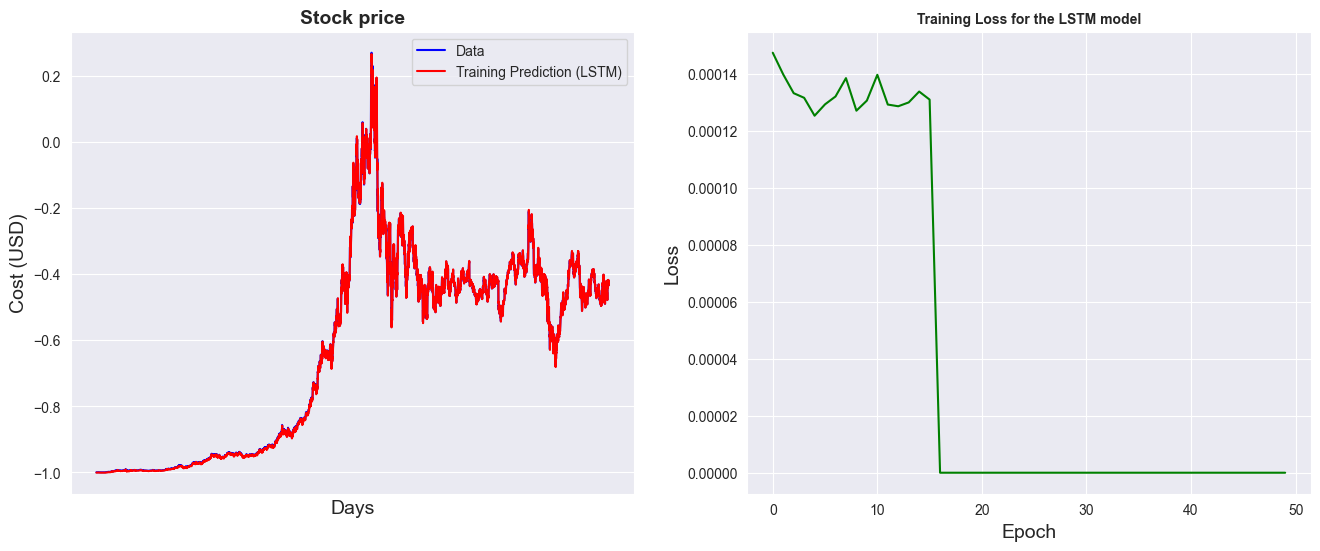

In [54]:
# Visualizing the training prediction
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)
original = pd.DataFrame(y_train_lstm.cpu().numpy())
predict = pd.DataFrame(model(x_train).detach().cpu().numpy())
plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='blue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='red')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticks([])
plt.savefig('images/lstm_prediction.png')


# Visualizing the training loss
plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='green')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss for the LSTM model", size = 10, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)
plt.savefig('images/lstm_training_loss.png')

# The training prediction for the LSTM model is really good.

## Evaluate the Model

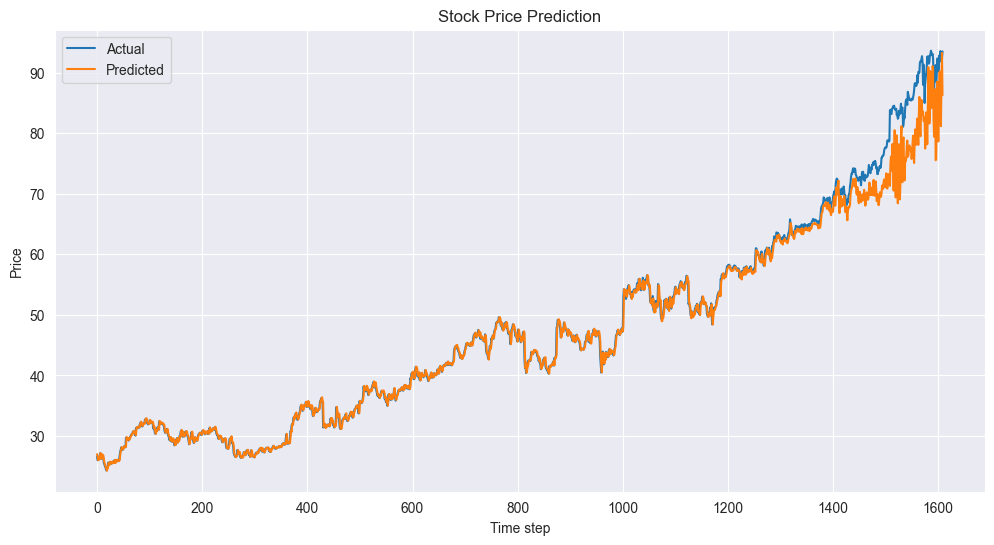

In [55]:
def evaluate_model(model, x_test, y_test, scaler):
    model.eval()
    with torch.no_grad():
        predictions = model(x_test).to(device)
        true_values = y_test.cpu().numpy()

    # Inverse scale
    predictions_rescaled = scaler.inverse_transform(predictions.cpu().numpy())

    true_rescaled = scaler.inverse_transform(true_values)

    return predictions_rescaled, true_rescaled

predicted, actual = evaluate_model(model, x_test, y_test_lstm, scaler)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(actual, label="Actual")
plt.plot(predicted, label="Predicted")
plt.title("Stock Price Prediction")
plt.xlabel("Time step")
plt.ylabel("Price")
plt.legend()
plt.savefig('images/lstm_prediction.png')
plt.show()

# The model was performing better at the training dataset than the test dataset, which is a common issue in machine learning when overfitting occurs.
# LSTM model is composed of a cell, an input gate, an output gate, and a forget gate. This complicated model needs a lot of data to train properly
# If the model is trained on a small dataset (like the one I used here), it can lead to overfitting, where the model learns the training data too well and fails to generalize to new data.

# Results on a Table

In [58]:

train_mse, val_mse, train_time = train_model(model, loss_fn, optimizer, train_loader, val_loader, num_epochs=50)


model.eval()
with torch.no_grad():
    test_predictions = model(x_test)
    test_mse = loss_fn(test_predictions, y_test_lstm).item()


results = pd.DataFrame({
    "Metric": ["Train MSE", "Validation MSE", "Test MSE", "Training Time (s)"],
    "Value": [train_mse, val_mse, test_mse, train_time]
})




Epoch 1/50, Train Loss: 0.000127, Val Loss: 0.001264
Epoch 2/50, Train Loss: 0.000125, Val Loss: 0.001664
Epoch 3/50, Train Loss: 0.000129, Val Loss: 0.004625
Epoch 4/50, Train Loss: 0.000127, Val Loss: 0.000799
Epoch 5/50, Train Loss: 0.000129, Val Loss: 0.000876
Epoch 6/50, Train Loss: 0.000127, Val Loss: 0.004146
Epoch 7/50, Train Loss: 0.000129, Val Loss: 0.001316
Epoch 8/50, Train Loss: 0.000124, Val Loss: 0.000588
Epoch 9/50, Train Loss: 0.000127, Val Loss: 0.002354
Epoch 10/50, Train Loss: 0.000127, Val Loss: 0.001444
Epoch 11/50, Train Loss: 0.000126, Val Loss: 0.000490
Epoch 12/50, Train Loss: 0.000123, Val Loss: 0.001818
Epoch 13/50, Train Loss: 0.000128, Val Loss: 0.000360
Epoch 14/50, Train Loss: 0.000128, Val Loss: 0.002802
Epoch 15/50, Train Loss: 0.000126, Val Loss: 0.001937
Epoch 16/50, Train Loss: 0.000125, Val Loss: 0.001268
Epoch 17/50, Train Loss: 0.000123, Val Loss: 0.000692
Epoch 18/50, Train Loss: 0.000126, Val Loss: 0.001164
Epoch 19/50, Train Loss: 0.000125, Va

In [59]:
print(results)

              Metric      Value
0          Train MSE   0.000127
1     Validation MSE   0.001854
2           Test MSE   0.001754
3  Training Time (s)  32.837398
